# Random Forest

Basic Random Forest

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from scipy.stats import randint

with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

#remove columns with single unique value
df = df.drop(columns = ['Unnamed: 0'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

def replace_spaces_with_commas(emb_str):
    return emb_str.replace(' ', ',')

# Apply the function to the embeddings column
df['embeddings'] = df['embeddings'].apply(replace_spaces_with_commas)

# Function to extract the list from the string representation
def extract_list(emb_str):
    # Remove outer brackets and convert the string to a list
    return eval(emb_str.strip("[]"))

# Apply the function and create a DataFrame from the list of embeddings
embeddings_split = df['embeddings'].apply(extract_list).apply(pd.Series)

# Rename columns to reflect the split embedding positions
embeddings_split.columns = [f'embedding_{i}' for i in range(embeddings_split.shape[1])]

# Concatenate the original DataFrame with the new embeddings DataFrame
df = pd.concat([df, embeddings_split], axis=1)
df = df.drop(['embeddings'], axis=1)

#spliting the columns according to their types
num_col = df.select_dtypes(['int64', 'int32', 'float64'])
num_col = num_col.drop(columns = ['majority_target'])
obj_col = df.select_dtypes('object')

# Threshold for correlation
corr_matrix = num_col.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

# Drop highly correlated numerical features--anything with threshold > 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df = df.drop(to_drop, axis=1)

# Separate features and target variable
X = df.drop(['statement', 'tweet', 'majority_target', 'BinaryNumTarget'] , axis=1)
y = df['majority_target']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Define the Random Forest model and hyperparameters
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
f1_scorer = make_scorer(f1_score, pos_label=0) 

# Set up RandomizedSearchCV with the F1 scorer
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_dist, 
    n_iter=6, 
    cv=2, 
    scoring=f1_scorer,  # Prioritize F1 score
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model with RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Make predictions and evaluate the model
y_pred = best_rf_model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Random Forest F1 Score: {f1:.4f}")

# Classification Report
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix to understand predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 107}
Random Forest Accuracy: 0.6772
Random Forest F1 Score: 0.6772

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.66      0.67      0.67     19442
        Real       0.69      0.68      0.69     20818

    accuracy                           0.68     40260
   macro avg       0.68      0.68      0.68     40260
weighted avg       0.68      0.68      0.68     40260


Confusion Matrix:
[[13009  6433]
 [ 6563 14255]]


Random Forest + RFE

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.feature_selection import RFE
from scipy.stats import randint

# Load the dataset
df = pd.read_csv("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv")

# Remove unnecessary and duplicate columns
df = df.drop(columns=['Unnamed: 0'])
df = df.loc[:, df.nunique() > 1]  # Keep only columns with more than one unique value
df = df.drop_duplicates()  # Remove duplicate rows

# Convert boolean columns to integers (0 and 1)
df['majority_target'] = df['majority_target'].astype(int)

# Replace spaces in embeddings with commas and parse into lists
def replace_spaces_with_commas(emb_str):
    return emb_str.replace(' ', ',')

df['embeddings'] = df['embeddings'].apply(replace_spaces_with_commas)

# Function to extract list from string representation
def extract_list(emb_str):
    return eval(emb_str.strip("[]"))

# Apply function and create DataFrame from embeddings
embeddings_split = df['embeddings'].apply(extract_list).apply(pd.Series)
embeddings_split.columns = [f'embedding_{i}' for i in range(embeddings_split.shape[1])]

# Concatenate embeddings with the main DataFrame and drop the original embeddings column
df = pd.concat([df, embeddings_split], axis=1)
df = df.drop(['embeddings'], axis=1)

# Separate numerical and object columns, excluding the target
num_col = df.select_dtypes(['int64', 'int32', 'float64']).drop(columns=['majority_target'])
obj_col = df.select_dtypes('object')

# Drop highly correlated numerical features (correlation threshold > 0.75)
corr_matrix = num_col.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df = df.drop(to_drop, axis=1)

# Separate features and target variable
X = df.drop(['majority_target', 'statement', 'tweet', 'BinaryNumTarget'], axis=1)
y = df['majority_target']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit Recursive Feature Elimination with Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=20)
rfe.fit(X_train, y_train)

# Select the top features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Use only the selected features for training and testing
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Define the Random Forest model and hyperparameters
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
f1_scorer = make_scorer(f1_score, pos_label=0) 

# Set up RandomizedSearchCV with the F1 scorer
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_dist, 
    n_iter=6, 
    cv=2, 
    scoring=f1_scorer,  # Prioritize F1 score
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model with RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Make predictions and evaluate the model
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Random Forest F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix for test predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Selected Features: Index(['followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'cred', 'normalize_influence', 'hashtags', 'URLs',
       'unique_count', 'PERSON_percentage', 'MONEY_percentage',
       'CARDINAL_percentage', 'Word count', 'Average word length',
       'past_verbs', 'adjectives', 'pronouns', 'capitals', 'digits',
       'embedding_10'],
      dtype='object')
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Parameters: {'bootstrap': True, 'max_depth': 45, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 199}
Random Forest Accuracy: 0.6528
Random Forest F1 Score: 0.6528

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.64      0.64      0.64     19442
        Real       0.66      0.66      0.66     20818

    accuracy                           0.65     40260
   macro avg       0.65      0.65      0.65     40260
weighted avg       0.65      0.65      0.65     40260



Random Forest + TF-IDF

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from scipy.stats import randint

with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

#remove columns with single unique value
df = df.drop(columns = ['Unnamed: 0'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

def replace_spaces_with_commas(emb_str):
    return emb_str.replace(' ', ',')

# Apply the function to the embeddings column
df['embeddings'] = df['embeddings'].apply(replace_spaces_with_commas)

# Function to extract the list from the string representation
def extract_list(emb_str):
    # Remove outer brackets and convert the string to a list
    return eval(emb_str.strip("[]"))

# Apply the function and create a DataFrame from the list of embeddings
embeddings_split = df['embeddings'].apply(extract_list).apply(pd.Series)

# Rename columns to reflect the split embedding positions
embeddings_split.columns = [f'embedding_{i}' for i in range(embeddings_split.shape[1])]

# Concatenate the original DataFrame with the new embeddings DataFrame
df = pd.concat([df, embeddings_split], axis=1)
df = df.drop(['embeddings'], axis=1)

#spliting the columns according to their types
num_col = df.select_dtypes(['int64', 'int32', 'float64'])
num_col = num_col.drop(columns = ['majority_target'])
obj_col = df.select_dtypes('object')

# Threshold for correlation
corr_matrix = num_col.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

# Drop highly correlated numerical features--anything with threshold > 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df = df.drop(to_drop, axis=1)

# Separate features and target variable
X = df.drop(['majority_target', 'statement', 'BinaryNumTarget'], axis=1)
y = df['majority_target']

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000) 

# Fit and transform the statement and tweet columns
tweet_tfidf = tfidf_vectorizer.fit_transform(df['tweet'])

# Combine TF-IDF reduced features with the rest of your features
extra_features = X.drop(columns=['tweet'])  # Drop non-feature columns

# Convert extra features to a sparse matrix
extra_features_sparse = csr_matrix(extra_features.values)

# Combine the extra sparse features with the reduced TF-IDF features
combined_features = hstack([extra_features_sparse, csr_matrix(tweet_tfidf)])  # Combine both as sparse matrices

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.3, random_state=42)

# Define the Random Forest model and hyperparameters
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
f1_scorer = make_scorer(f1_score, pos_label=0) 

# Set up RandomizedSearchCV with the F1 scorer
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_dist, 
    n_iter=6, 
    cv=2, 
    scoring=f1_scorer,  # Prioritize F1 score
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model with RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Make predictions and evaluate the model
y_pred = best_rf_model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Random Forest F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix to understand predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 107}
Random Forest Accuracy: 0.8754
Random Forest F1 Score: 0.8748

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.92      0.81      0.86     19442
        Real       0.84      0.94      0.89     20818

    accuracy                           0.88     40260
   macro avg       0.88      0.87      0.87     40260
weighted avg       0.88      0.88      0.87     40260


Confusion Matrix:
[[15768  3674]
 [ 1341 19477]]


Random Forest + TF-IDF + TruncatedSVD

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
from scipy.sparse import hstack, csr_matrix
from scipy.stats import randint

with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

#remove columns with single unique value
df = df.drop(columns = ['Unnamed: 0'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

def replace_spaces_with_commas(emb_str):
    return emb_str.replace(' ', ',')

# Apply the function to the embeddings column
df['embeddings'] = df['embeddings'].apply(replace_spaces_with_commas)

# Function to extract the list from the string representation
def extract_list(emb_str):
    # Remove outer brackets and convert the string to a list
    return eval(emb_str.strip("[]"))

# Apply the function and create a DataFrame from the list of embeddings
embeddings_split = df['embeddings'].apply(extract_list).apply(pd.Series)

# Rename columns to reflect the split embedding positions
embeddings_split.columns = [f'embedding_{i}' for i in range(embeddings_split.shape[1])]

# Concatenate the original DataFrame with the new embeddings DataFrame
df = pd.concat([df, embeddings_split], axis=1)
df = df.drop(['embeddings'], axis=1)

#spliting the columns according to their types
num_col = df.select_dtypes(['int64', 'int32', 'float64'])
num_col = num_col.drop(columns = ['majority_target'])
obj_col = df.select_dtypes('object')

# Threshold for correlation
corr_matrix = num_col.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

# Drop highly correlated numerical features--anything with threshold > 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df = df.drop(to_drop, axis=1)

# Separate features and target variable
X = df.drop(['majority_target', 'statement', 'BinaryNumTarget'], axis=1)
y = df['majority_target']

# Create a TF-IDF vectorizer with a limited vocabulary size
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit to top 5000 words
tfidf_features = vectorizer.fit_transform(df['tweet'])  # Keep this as a sparse matrix

# Apply TruncatedSVD for dimensionality reduction on TF-IDF features
svd = TruncatedSVD(n_components=100, random_state=42)  # Reduce to 100 components
tfidf_reduced = svd.fit_transform(tfidf_features)

# Combine TF-IDF reduced features with the rest of your features
extra_features = X.drop(columns=['tweet'])  # Drop non-feature columns

# Convert extra features to a sparse matrix
extra_features_sparse = csr_matrix(extra_features.values)

# Combine the extra sparse features with the reduced TF-IDF features
combined_features = hstack([extra_features_sparse, csr_matrix(tfidf_reduced)])  # Combine both as sparse matrices

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.3, random_state=42)

# Define the Random Forest model and hyperparameters
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
f1_scorer = make_scorer(f1_score, pos_label=0) 

# Set up RandomizedSearchCV with the F1 scorer
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_dist, 
    n_iter=6, 
    cv=2, 
    scoring=f1_scorer,  # Prioritize F1 score
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model with RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Make predictions and evaluate the model
y_pred = best_rf_model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Random Forest F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report: ")
print(classification_report(y_test, y_pred))

# Confusion Matrix to understand predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 107}
Random Forest Accuracy: 0.9066
Random Forest F1 Score: 0.9066

Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     19442
           1       0.90      0.92      0.91     20818

    accuracy                           0.91     40260
   macro avg       0.91      0.91      0.91     40260
weighted avg       0.91      0.91      0.91     40260


Confusion Matrix:
[[17305  2137]
 [ 1623 19195]]


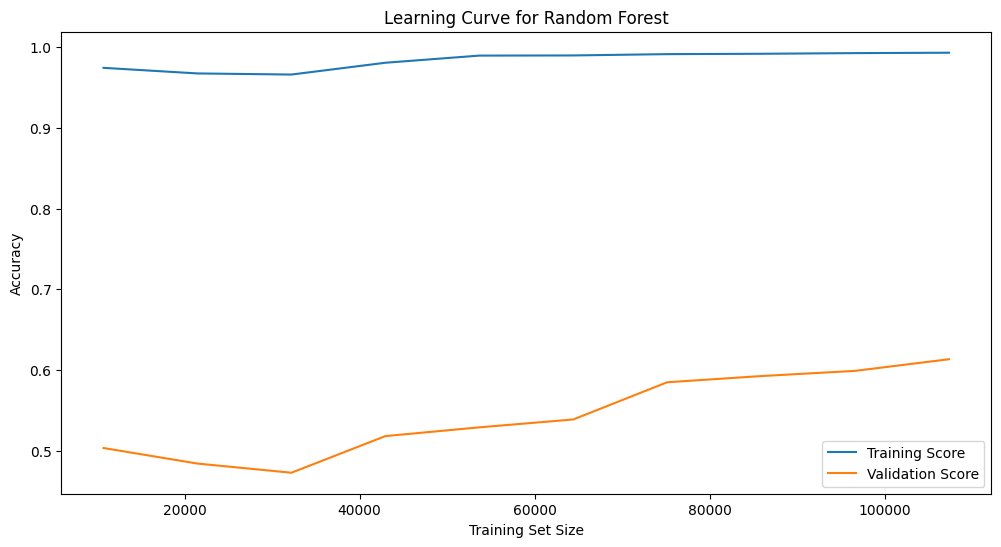

In [29]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_rf_model, combined_features, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Random Forest")
plt.legend()
plt.show()

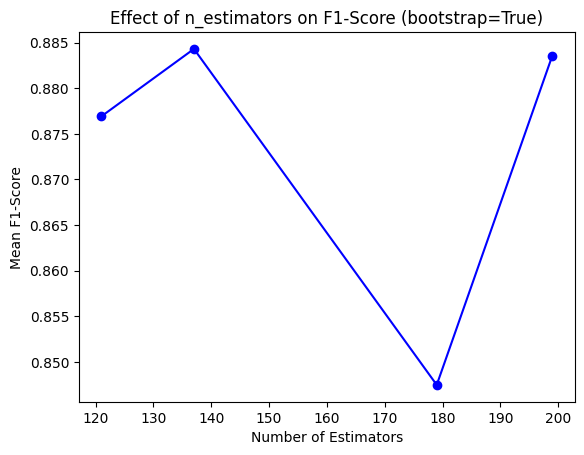

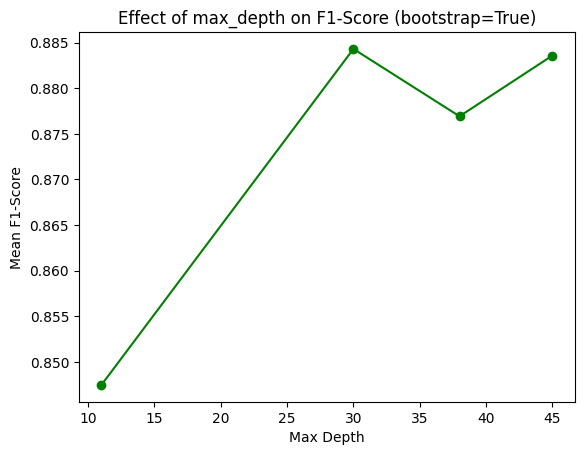

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert cv_results_ to DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Filter for rows where bootstrap=True
results_bootstrap_true = results[results['param_bootstrap'] == True]

# Plot n_estimators vs. mean_test_score (mean F1-score) for bootstrap=True
results_bootstrap_true = results_bootstrap_true.sort_values(by='param_n_estimators')
plt.plot(results_bootstrap_true['param_n_estimators'], results_bootstrap_true['mean_test_score'], marker='o', color='blue', linestyle='-')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean F1-Score')
plt.title('Effect of n_estimators on F1-Score (bootstrap=True)')
plt.show()

# Plot max_depth vs. mean_test_score (mean F1-score) for bootstrap=True if max_depth was a parameter
if 'param_max_depth' in results.columns:
    results_bootstrap_true = results_bootstrap_true.sort_values(by='param_max_depth')
    plt.plot(results_bootstrap_true['param_max_depth'], results_bootstrap_true['mean_test_score'], marker='o', color='green', linestyle='-')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean F1-Score')
    plt.title('Effect of max_depth on F1-Score (bootstrap=True)')
    plt.show()

Random Forest + TF-IDF + TruncatedSVD + Lemmatizer & Stopwords

In [24]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
from scipy.sparse import hstack, csr_matrix
from scipy.stats import randint
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')

with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

#remove columns with single unique value
df = df.drop(columns = ['Unnamed: 0'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

def replace_spaces_with_commas(emb_str):
    return emb_str.replace(' ', ',')

# Apply the function to the embeddings column
df['embeddings'] = df['embeddings'].apply(replace_spaces_with_commas)

# Function to extract the list from the string representation
def extract_list(emb_str):
    # Remove outer brackets and convert the string to a list
    return eval(emb_str.strip("[]"))

# Apply the function and create a DataFrame from the list of embeddings
embeddings_split = df['embeddings'].apply(extract_list).apply(pd.Series)

# Rename columns to reflect the split embedding positions
embeddings_split.columns = [f'embedding_{i}' for i in range(embeddings_split.shape[1])]

# Concatenate the original DataFrame with the new embeddings DataFrame
df = pd.concat([df, embeddings_split], axis=1)
df = df.drop(['embeddings'], axis=1)

#spliting the columns according to their types
num_col = df.select_dtypes(['int64', 'int32', 'float64'])
num_col = num_col.drop(columns = ['majority_target'])
obj_col = df.select_dtypes('object')

# Threshold for correlation
corr_matrix = num_col.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

# Drop highly correlated numerical features--anything with threshold > 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df = df.drop(to_drop, axis=1)

# Separate features and target variable
X = df.drop(['majority_target', 'statement', 'BinaryNumTarget'], axis=1)
y = df['majority_target']

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess a single tweet
def preprocess_tweet(tweet):
    # 1. Convert to lowercase
    tweet = tweet.lower()
    
    # 2. Remove URLs, mentions (@username), hashtags, and special characters
#     tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet)  # Remove URLs
#     tweet = re.sub(r'@\w+|\#', '', tweet)  # Remove mentions and hashtags
#     tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation and special characters
    
    # 3. Tokenization (split the tweet into words)
    words = tweet.split()
    
    # 4. Remove stopwords and apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # Join the words back into a single string
    return ' '.join(words)

# Apply preprocessing to the 'tweet' column
X['processed_tweet'] = X['tweet'].apply(preprocess_tweet)

# Convert tweets to TF-IDF features
tweets = X['processed_tweet'].astype(str).values
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = vectorizer.fit_transform(tweets)

# Reduce TF-IDF dimensionality using TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_features)

X_other = X.drop(['tweet','processed_tweet'], axis=1, errors='ignore')

# Convert X_other to sparse format
X_other_sparse = csr_matrix(X_other.values)

# Combine the reduced TF-IDF features with the other features
X_combined = hstack([X_other_sparse, csr_matrix(tfidf_reduced)])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# Define the Random Forest model and hyperparameters
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
f1_scorer = make_scorer(f1_score, pos_label=0)

# Set up RandomizedSearchCV with the F1 scorer
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_dist, 
    n_iter=6, 
    cv=2, 
    scoring=f1_scorer,  # Prioritize F1 score
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model with RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Make predictions and evaluate the model
y_pred = best_rf_model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Random Forest F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix to understand predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laiye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laiye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 107}
Random Forest Accuracy: 0.8999
Random Forest F1 Score: 0.8998

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.91      0.88      0.89     19442
        Real       0.89      0.92      0.90     20818

    accuracy                           0.90     40260
   macro avg       0.90      0.90      0.90     40260
weighted avg       0.90      0.90      0.90     40260


Confusion Matrix:
[[17039  2403]
 [ 1628 19190]]
